**Transfer learning with pretrained Keras model**

In this notebook, we used a pre-trained Xception model to predict images in Plant Seedlings Classification competition.

In order to use the pre-trained weights for the Xception model, need to add a new dataset containing the weights. Go to the Data tab and click on 'Add Data'. Then search for the 'Keras Pretrained Model' dataset and add it. Also need to add input data, for that click on 'Add Data'. Go to the competitions tab and then search for the 'Plant Seedlings Classification' dataset and add it.

**Importing all the necessary modules:**

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 16
import numpy as np
import os
import pandas as pd
import seaborn as sns
from keras.applications import xception
from keras.preprocessing import image
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm import tqdm

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Use Keras Pretrained Models dataset and copy the pretrained models(xception) to the cache directory (~/.keras/models)

In [3]:
!ls ../input/keras-pretrained-models/

Kuszma.JPG
imagenet_class_index.json
inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5
inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5
inception_v3_weights_tf_dim_ordering_tf_kernels.h5
inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
resnet50_weights_tf_dim_ordering_tf_kernels.h5
resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5
xception_weights_tf_dim_ordering_tf_kernels.h5
xception_weights_tf_dim_ordering_tf_kernels_notop.h5


In [4]:
cache_dir = os.path.expanduser(os.path.join('~', '.keras'))
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)
models_dir = os.path.join(cache_dir, 'models')
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

In [5]:
!cp ../input/keras-pretrained-models/xception* ~/.keras/models/

In [6]:
!ls ~/.keras/models

xception_weights_tf_dim_ordering_tf_kernels.h5
xception_weights_tf_dim_ordering_tf_kernels_notop.h5


**Check the plant seedlings Dataset**

In [7]:
!ls ../input/plant-seedlings-classification

sample_submission.csv  test  train


In [8]:
CATEGORIES = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent',
              'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
NUM_CATEGORIES = len(CATEGORIES)

In [9]:
SAMPLE_PER_CATEGORY = 200
SEED = 1987
data_dir = '../input/plant-seedlings-classification/'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
sample_submission = pd.read_csv(os.path.join(data_dir, 'sample_submission.csv'))

In [10]:
sample_submission.head(2)

,file,species
0,0021e90e4.png,Sugar beet
1,003d61042.png,Sugar beet


In [11]:
for category in CATEGORIES:
    print('{} {} images'.format(category, len(os.listdir(os.path.join(train_dir, category)))))

Black-grass 263 images
Charlock 390 images
Cleavers 287 images
Common Chickweed 611 images
Common wheat 221 images
Fat Hen 475 images
Loose Silky-bent 654 images
Maize 221 images
Scentless Mayweed 516 images
Shepherds Purse 231 images
Small-flowered Cranesbill 496 images
Sugar beet 385 images


In [12]:
train = []
for category_id, category in enumerate(CATEGORIES):
    for file in os.listdir(os.path.join(train_dir, category)):
        train.append(['train/{}/{}'.format(category, file), category_id, category])
train = pd.DataFrame(train, columns=['file', 'category_id', 'category'])
train.head(2)
train.shape

,file,category_id,category
0,train/Black-grass/2aa60045d.png,0,Black-grass
1,train/Black-grass/a47cfeec4.png,0,Black-grass


(4750, 3)

**Training sample**

In [13]:
train = pd.concat([train[train['category'] == c][:SAMPLE_PER_CATEGORY] for c in CATEGORIES])
train = train.sample(frac=1)
train.index = np.arange(len(train))
train.head(2)
train.shape

,file,category_id,category
0,train/Shepherds Purse/8e1efae9e.png,9,Shepherds Purse
1,train/Shepherds Purse/150ab985f.png,9,Shepherds Purse


(2400, 3)

In [14]:
test = []
for file in os.listdir(test_dir):
    test.append(['test/{}'.format(file), file])
test = pd.DataFrame(test, columns=['filepath', 'file'])
test.head(2)
test.shape

,filepath,file
0,test/fd87b36ae.png,fd87b36ae.png
1,test/0e8492cb1.png,0e8492cb1.png


(794, 2)

In [15]:
def read_img(filepath, size):
    img = image.load_img(os.path.join(data_dir, filepath), target_size=size)
    img = image.img_to_array(img)
    return img

**Example images**

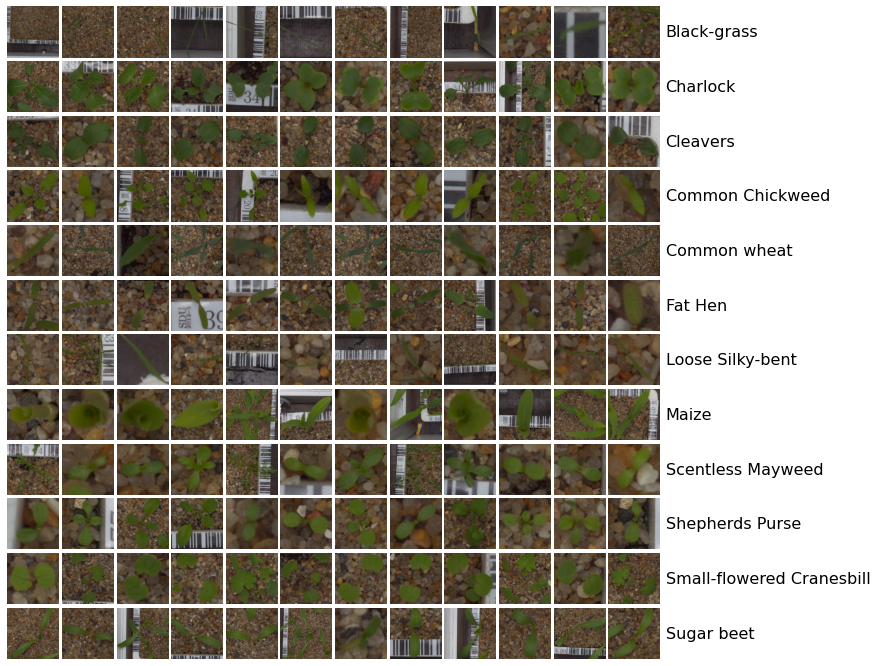

In [16]:
fig = plt.figure(1, figsize=(NUM_CATEGORIES, NUM_CATEGORIES))
grid = ImageGrid(fig, 111, nrows_ncols=(NUM_CATEGORIES, NUM_CATEGORIES), axes_pad=0.05)
i = 0
for category_id, category in enumerate(CATEGORIES):
    for filepath in train[train['category'] == category]['file'].values[:NUM_CATEGORIES]:
        ax = grid[i]
        img = read_img(filepath, (224, 224))
        ax.imshow(img / 255.)
        ax.axis('off')
        if i % NUM_CATEGORIES == NUM_CATEGORIES - 1:
            ax.text(250, 112, filepath.split('/')[1], verticalalignment='center')
        i += 1
plt.show();

**Validation split**

In [17]:
np.random.seed(seed=SEED)
rnd = np.random.random(len(train))
train_idx = rnd < 0.8
valid_idx = rnd >= 0.8
ytr = train.loc[train_idx, 'category_id'].values
yv = train.loc[valid_idx, 'category_id'].values
len(ytr), len(yv)

(1899, 501)

**Extract Xception bottleneck features**

In [18]:
INPUT_SIZE = 299
POOLING = 'avg'
x_train = np.zeros((len(train), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
for i, file in tqdm(enumerate(train['file'])):
    img = read_img(file, (INPUT_SIZE, INPUT_SIZE))
    x = xception.preprocess_input(np.expand_dims(img.copy(), axis=0))
    x_train[i] = x
print('Train Images shape: {} size: {:,}'.format(x_train.shape, x_train.size))

2400it [01:02, 38.27it/s]

Train Images shape: (2400, 299, 299, 3) size: 643,687,200


In [19]:
Xtr = x_train[train_idx]
Xv = x_train[valid_idx]
print((Xtr.shape, Xv.shape, ytr.shape, yv.shape))
xception_bottleneck = xception.Xception(weights='imagenet', include_top=False, pooling=POOLING)
train_x_bf = xception_bottleneck.predict(Xtr, batch_size=32, verbose=1)
valid_x_bf = xception_bottleneck.predict(Xv, batch_size=32, verbose=1)
print('Xception train bottleneck features shape: {} size: {:,}'.format(train_x_bf.shape, train_x_bf.size))
print('Xception valid bottleneck features shape: {} size: {:,}'.format(valid_x_bf.shape, valid_x_bf.size))

((1899, 299, 299, 3), (501, 299, 299, 3), (1899,), (501,))
16/16 [==============================] - 2s 159ms/step
Xception train bottleneck features shape: (1899, 2048) size: 3,889,152
Xception valid bottleneck features shape: (501, 2048) size: 1,026,048


**LogReg on Xception bottleneck features**

In [20]:
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=SEED)
logreg.fit(train_x_bf, ytr)
valid_probs = logreg.predict_proba(valid_x_bf)
valid_preds = logreg.predict(valid_x_bf)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(multi_class='multinomial', random_state=1987)

In [21]:
print('Validation Xception Accuracy {}'.format(accuracy_score(yv, valid_preds)))

Validation Xception Accuracy 0.8363273453093812


**Confusion matrix**

In [22]:
cnf_matrix = confusion_matrix(yv, valid_preds)

In [23]:
abbreviation = ['BG', 'Ch', 'Cl', 'CC', 'CW', 'FH', 'LSB', 'M', 'SM', 'SP', 'SFC', 'SB']
pd.DataFrame({'class': CATEGORIES, 'abbreviation': abbreviation})

,class,abbreviation
0,Black-grass,BG
1,Charlock,Ch
2,Cleavers,Cl
3,Common Chickweed,CC
4,Common wheat,CW
5,Fat Hen,FH
6,Loose Silky-bent,LSB
7,Maize,M
8,Scentless Mayweed,SM
9,Shepherds Purse,SP


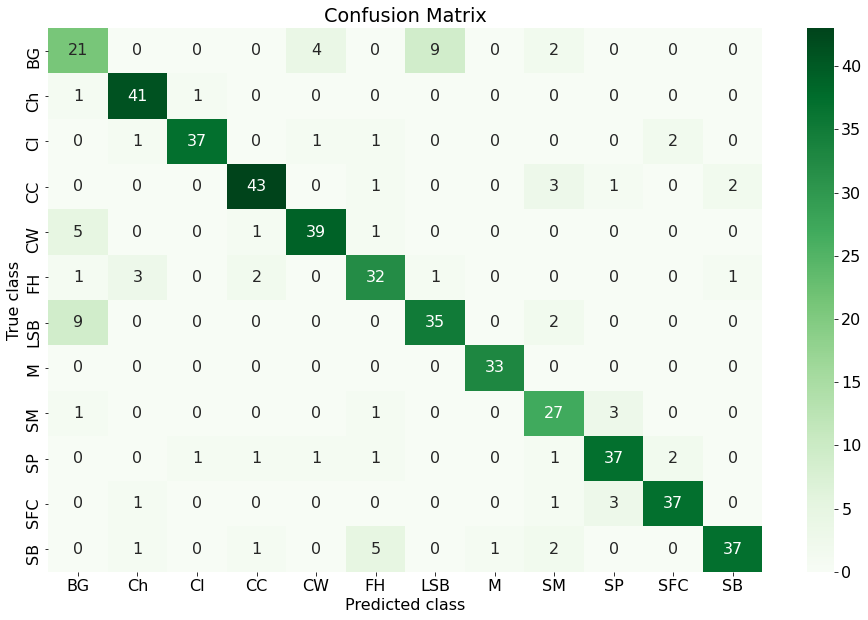

In [24]:
fig, ax = plt.subplots(1)
ax = sns.heatmap(cnf_matrix, ax=ax, cmap=plt.cm.Greens, annot=True)
ax.set_xticklabels(abbreviation)
ax.set_yticklabels(abbreviation)
plt.title('Confusion Matrix')
plt.ylabel('True class')
plt.xlabel('Predicted class')
fig.savefig('Confusion matrix.png', dpi=300)
plt.show();

**Create submission**

In [25]:
x_test = np.zeros((len(test), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
for i, filepath in tqdm(enumerate(test['filepath'])):
    img = read_img(filepath, (INPUT_SIZE, INPUT_SIZE))
    x = xception.preprocess_input(np.expand_dims(img.copy(), axis=0))
    x_test[i] = x
print('test Images shape: {} size: {:,}'.format(x_test.shape, x_test.size))

794it [00:08, 90.71it/s]

test Images shape: (794, 299, 299, 3) size: 212,953,182


In [26]:
test_x_bf = xception_bottleneck.predict(x_test, batch_size=32, verbose=1)
print('Xception test bottleneck features shape: {} size: {:,}'.format(test_x_bf.shape, test_x_bf.size))
test_preds = logreg.predict(test_x_bf)

25/25 [==============================] - 4s 154ms/step
Xception test bottleneck features shape: (794, 2048) size: 1,626,112


In [27]:
test['category_id'] = test_preds
test['species'] = [CATEGORIES[c] for c in test_preds]
test[['file', 'species']].to_csv('xception_result_v4', index=False)